In [1]:

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/diamonds/diamonds.csv


Loading data

In [2]:
path = '/kaggle/input/diamonds/diamonds.csv'
data = pd.read_csv(path, index_col = 0)

In [3]:
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
num_cols = [col for col in data.columns if data[col].dtypes != 'O']

Removing outliers

In [5]:
def drop_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - IQR * 1.5
    high = Q3 + IQR * 1.5
    new_data = data[(data[column] >= low) & (data[column] <= high)]
    return new_data

In [6]:
new_data = data.copy()
for col in num_cols:
    new_data = drop_outliers(new_data, col)

In [7]:
X = new_data.drop(columns = ['price'])
y = new_data['price']

In [8]:
y.describe()

count    46532.000000
mean      2999.000107
std       2598.654394
min        326.000000
25%        880.000000
50%       2002.500000
75%       4523.000000
max      11040.000000
Name: price, dtype: float64

Oridinal encoding

In [9]:
s = (data.dtypes == 'object')
s_cols = list(s[s].index)
print(s_cols)

['cut', 'color', 'clarity']


In [10]:
new_X = X.copy()
encoder = OrdinalEncoder()
new_X[s_cols] = encoder.fit_transform(X[s_cols])
new_X

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,2.0,1.0,3.0,61.5,55.0,3.95,3.98,2.43
2,0.21,3.0,1.0,2.0,59.8,61.0,3.89,3.84,2.31
4,0.29,3.0,5.0,5.0,62.4,58.0,4.20,4.23,2.63
5,0.31,1.0,6.0,3.0,63.3,58.0,4.34,4.35,2.75
6,0.24,4.0,6.0,7.0,62.8,57.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...
53936,0.72,2.0,0.0,2.0,60.8,57.0,5.75,5.76,3.50
53937,0.72,1.0,0.0,2.0,63.1,55.0,5.69,5.75,3.61
53938,0.70,4.0,0.0,2.0,62.8,60.0,5.66,5.68,3.56
53939,0.86,3.0,4.0,3.0,61.0,58.0,6.15,6.12,3.74


In [11]:
train_X, val_X, train_y, val_y = train_test_split(new_X, y, random_state = 0)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


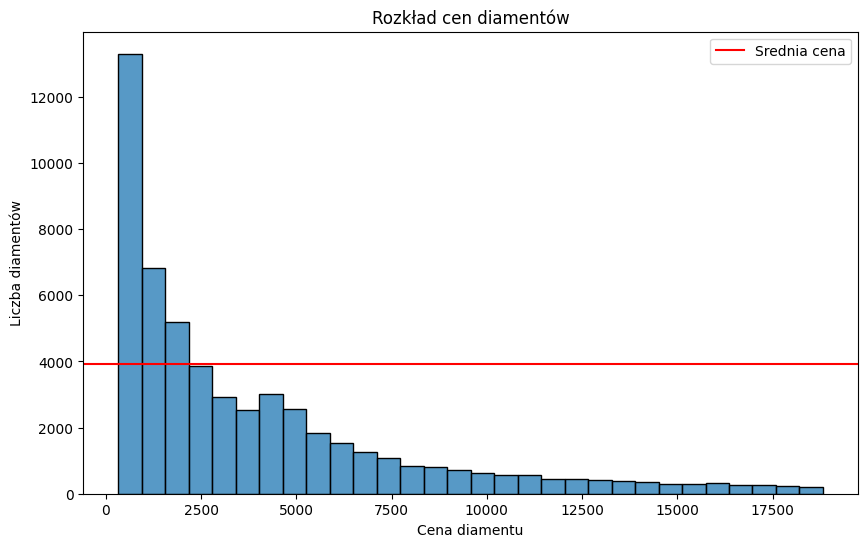

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30)  # kde=True dodaje krzywą gęstości
plt.xlabel('Cena diamentu')
plt.ylabel('Liczba diamentów')
plt.axhline(y=data.price.mean(), color = 'red', label='Srednia cena')
plt.legend()
plt.title('Rozkład cen diamentów')
plt.show()


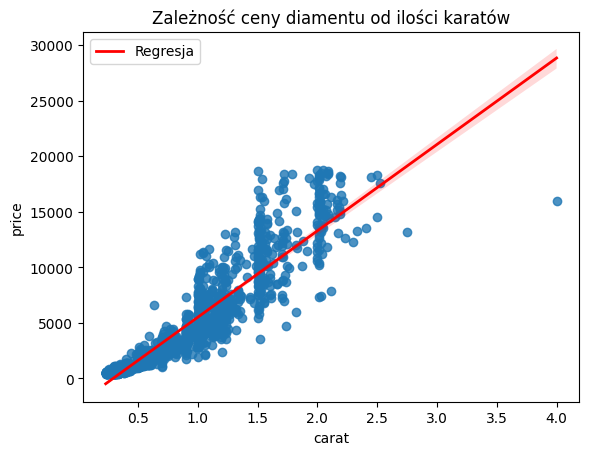

In [13]:
sample_data = data.sample(2000, random_state=42)
plt.title('Zależność ceny diamentu od ilości karatów')
sns.regplot(x=sample_data.carat, y=sample_data.price, line_kws={'color': 'red', 'linewidth': 2})
plt.plot([], [], color='red', linewidth=2, label='Regresja')
plt.legend()


In [14]:
model_DTR = DecisionTreeRegressor()
model_DTR.fit(train_X, train_y)


DecisionTreeRegressor()

In [15]:
predicted_prices_DTR = model_DTR.predict(val_X)
DTR_mean = mean_absolute_error(val_y, predicted_prices_DTR)
print(DTR_mean)

252.5522221267085


In [16]:
model_RFR = RandomForestRegressor()
model_RFR.fit(train_X, train_y)

RandomForestRegressor()

In [17]:
predicted_prices_RFR = model_RFR.predict(val_X)
RFR_mean = mean_absolute_error(val_y, predicted_prices_RFR)
print(RFR_mean)

192.37664521564955


In [18]:
model_LR = LinearRegression()
model_LR.fit(train_X, train_y)

LinearRegression()

In [19]:
predicted_prices_LR = model_LR.predict(val_X)
LR_mean = mean_absolute_error(val_y, predicted_prices_LR)
print(LR_mean)

574.9994569747371


In [20]:
model_XGB = XGBRegressor()
model_XGB.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
predicted_prices_XGB = model_XGB.predict(val_X)
XGB_mean = mean_absolute_error(val_y, predicted_prices_XGB)
print(XGB_mean)

194.03832406537774


In [22]:
XGB_means = []
r = 0 
LRs = [0.01, 0.05, 0.1, 0.2]
NEs = [10, 100, 1000, 2000]
MDs = [3, 5, 8, 10]
for lr in LRs:
    for ne in NEs:
        for md in MDs:
            print(f'{r}/63')
            model = XGBRegressor(learning_rate = lr, n_estimators=ne, max_depth = md, early_stopping_rounds = 10, eval_metric="mae")
            model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
            preds = model.predict(val_X)
            mean = mean_absolute_error(preds, val_y)
            XGB_means.append({'learning rate':lr, 'n_estimators':ne, 'max depth':md, 'MAE': mean})
            r +=1


0/63
1/63
2/63
3/63
4/63
5/63
6/63
7/63
8/63
9/63
10/63
11/63
12/63
13/63
14/63
15/63
16/63
17/63
18/63
19/63
20/63
21/63
22/63
23/63
24/63
25/63
26/63
27/63
28/63
29/63
30/63
31/63
32/63
33/63
34/63
35/63
36/63
37/63
38/63
39/63
40/63
41/63
42/63
43/63
44/63
45/63
46/63
47/63
48/63
49/63
50/63
51/63
52/63
53/63
54/63
55/63
56/63
57/63
58/63
59/63
60/63
61/63
62/63
63/63


In [23]:
df_means = pd.DataFrame(XGB_means)

df_sorted = df_means.sort_values(by='MAE', ascending=True)
df_sorted.head()

,learning rate,n_estimators,max depth,MAE
14,0.01,2000,8,183.983541
30,0.05,2000,8,184.645412
26,0.05,1000,8,184.645412
42,0.10,1000,8,185.167290
46,0.10,2000,8,185.167290


<Axes: xlabel='learning rate', ylabel='MAE'>

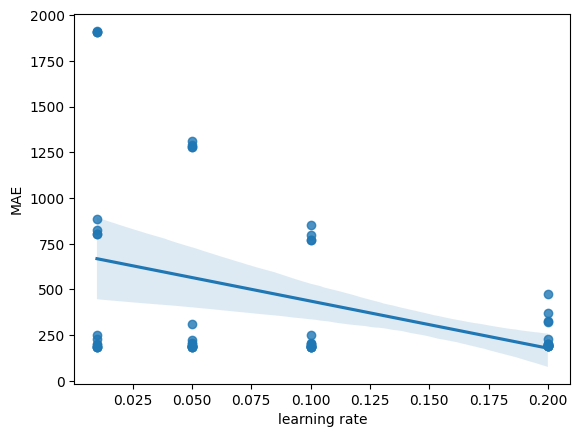

In [24]:
sns.regplot(x='learning rate', y='MAE', data = df_means)

<Axes: xlabel='max depth', ylabel='MAE'>

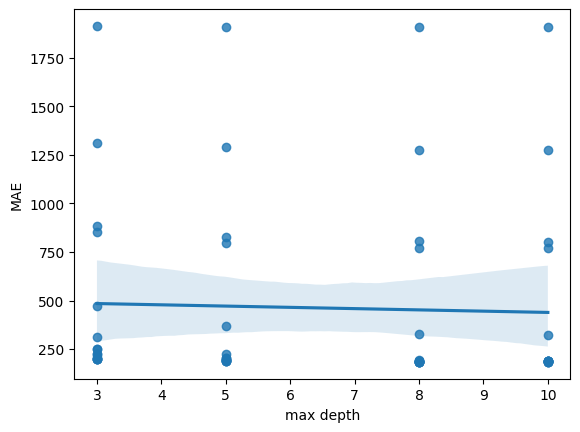

In [25]:
sns.regplot(x='max depth', y='MAE', data = df_means)

<Axes: xlabel='n_estimators', ylabel='MAE'>

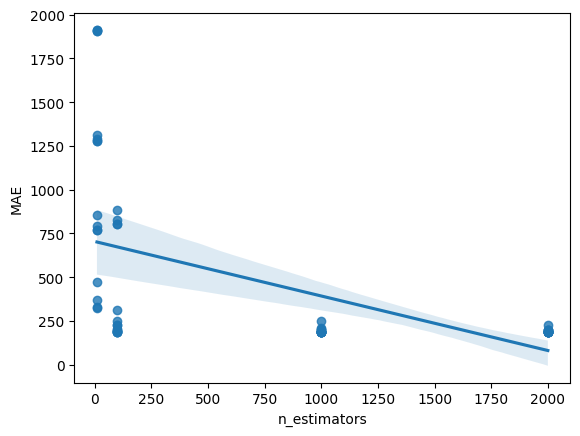

In [26]:
sns.regplot(x='n_estimators', y='MAE', data = df_means)

BEST: 0.01	2000	8	183.983541

In [27]:
best_XGB_model = XGBRegressor(learning_rate = 0.01, n_estimators=2000, max_depth = 8, early_stopping_rounds = 10, eval_metric="mae")
model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
predicted_prices_best_XGB= model.predict(val_X)
best_XGB_mean = mean_absolute_error(predicted_prices_best_XGB, val_y)

In [28]:
means = [RFR_mean, XGB_mean, best_XGB_mean, DTR_mean, LR_mean]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


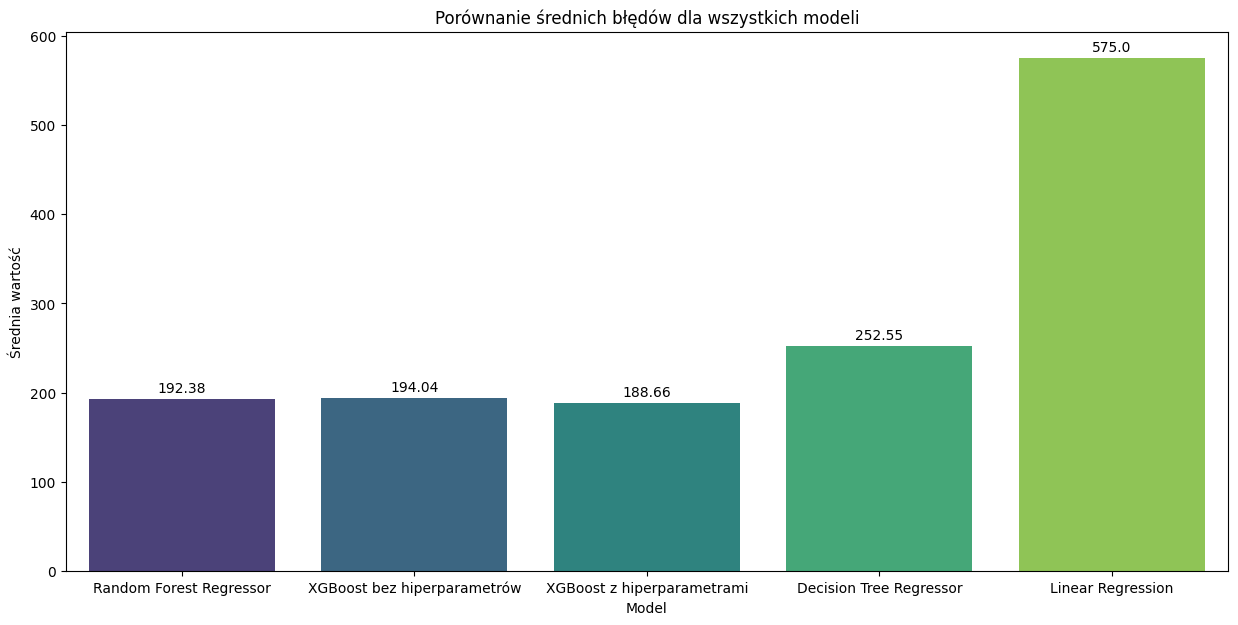

In [29]:
plt.figure(figsize=(15, 7))
models = ['Random Forest Regressor', 'XGBoost bez hiperparametrów', 'XGBoost z hiperparametrami', 'Decision Tree Regressor', 'Linear Regression']
sns.barplot(x=models, y=means, palette='viridis')
#plt.grid(axis='y')
for i, value in enumerate(means):
    plt.text(i, value + 20, f'{value.round(2)}', ha='center', va='top', fontsize=10)
plt.xlabel('Model')
plt.ylabel('Średnia wartość')
plt.title('Porównanie średnich błędów dla wszystkich modeli')
plt.show()

In [30]:
mean_act = val_y.mean()
rel_means = []
for m in means:
    rel_mean = (m/mean_act)*100
    rel_mean = rel_mean.round(2)
    rel_means.append(rel_mean)
rel_means    

[6.47, 6.53, 6.35, 8.5, 19.35]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


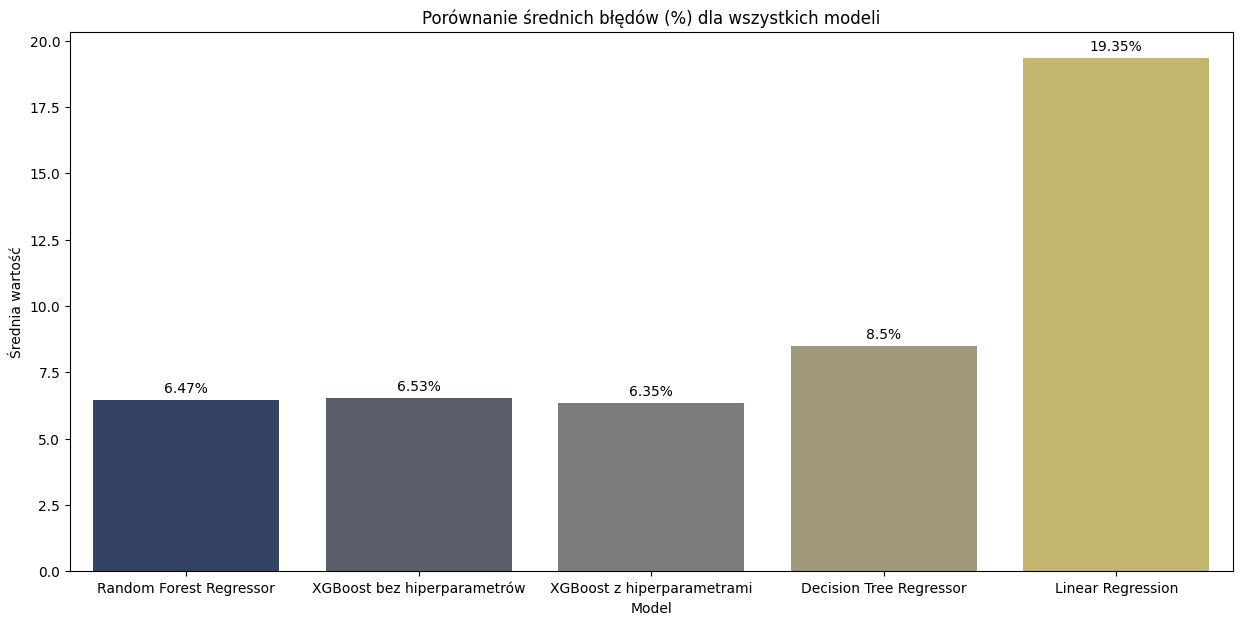

In [31]:
plt.figure(figsize=(15, 7))
models = ['Random Forest Regressor', 'XGBoost bez hiperparametrów', 'XGBoost z hiperparametrami', 'Decision Tree Regressor', 'Linear Regression']
sns.barplot(x=models, y=rel_means, palette='cividis')
#plt.grid(axis='y')
for i, value in enumerate(rel_means):
    plt.text(i, value+0.7, f'{value.round(2)}%', ha='center', va='top', fontsize=10)
plt.xlabel('Model')
plt.ylabel('Średnia wartość')
plt.title('Porównanie średnich błędów (%) dla wszystkich modeli')
plt.show()

In [32]:
pred_prices = [predicted_prices_RFR, predicted_prices_XGB, predicted_prices_best_XGB, predicted_prices_DTR, predicted_prices_LR]

In [33]:
r2s = []
for pred_price in pred_prices:
    r2 = r2_score(val_y, pred_price)
    r2s.append(r2)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


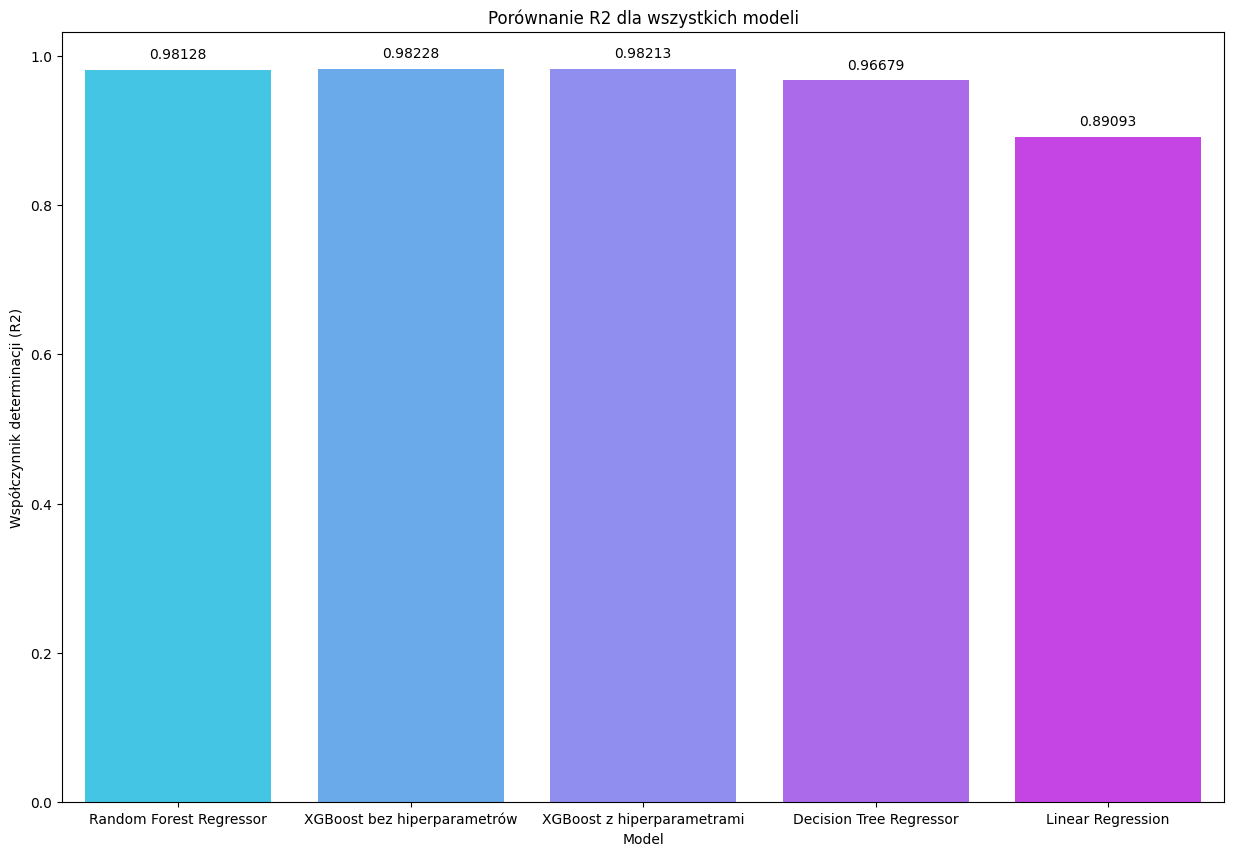

In [34]:
plt.figure(figsize=(15, 10))
models = ['Random Forest Regressor', 'XGBoost bez hiperparametrów', 'XGBoost z hiperparametrami', 'Decision Tree Regressor', 'Linear Regression']
sns.barplot(x=models, y=r2s, palette='cool')
#plt.grid(axis='y')
for i, value in enumerate(r2s):
    plt.text(i, value+0.03, f'{value.round(5)}', ha='center', va='top', fontsize=10)
plt.xlabel('Model')
plt.ylabel('Współczynnik determinacji (R2)')
plt.title('Porównanie R2 dla wszystkich modeli')
plt.show()

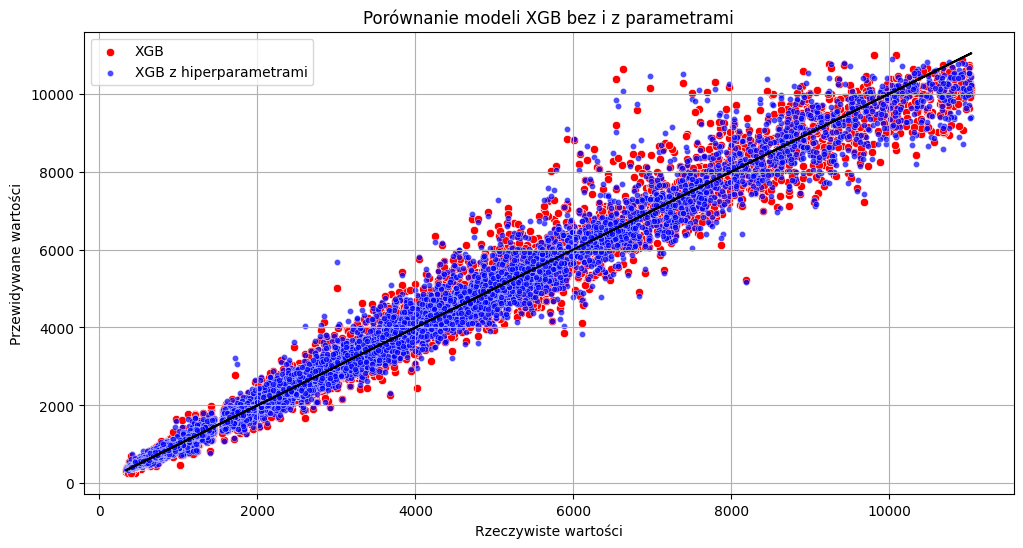

In [35]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=val_y, y=predicted_prices_XGB, label='XGB', color = 'red')
sns.scatterplot(x=val_y, y=predicted_prices_best_XGB, s = 20, alpha = 0.7, label='XGB z hiperparametrami', color = 'blue')
plt.grid()
plt.plot(val_y, val_y, color = 'black')
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Porównanie modeli XGB bez i z parametrami')
plt.legend()
plt.show()